# **Survivability Prediction After Heart Failure**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

> Goal : *build ML algorithms which can predict the survival chance of a patient suffering from heart failure*

For the sake of clarity, the patients in this dataset all suffered from heart failure. The dataset describes health parameters of these patients and their recovery status *following* their heart failure, a.k.a. their recovery (or not) after heart failure.


**Dataset**

*age*               : Age of the patient

*anaemia*           : Haemoglobin level of patient :   NO (0 )or YES (1)

*creatinine_phosphokinase* : Level of the CPK enzyme in the blood (mcg/L)

*diabetes*          : If the patient has diabetes      NO (0 )or YES (1)

*ejection_fraction* : Percentage of blood leaving the heart at each contraction

*high_blood_pressure*: If the patient has hypertension NO (0 )or YES (1)

*platelets*         : Platelet count of blood (kiloplatelets/mL)

*serum_creatinine*  : Level of serum creatinine in the blood (mg/dL)

*serum_sodium*      : Level of serum sodium in the blood (mEq/L)

*sex*               : Sex of the patient   FEMALE (0 )or MALE (1)

*smoking*          : If the patient smokes  NO (0 )or YES (1)

*time*              : Follow-up period (days)

*DEATH_EVENT*       : If the patient deceased during the follow-up period NO (0 )or YES (1)


In [4]:
## import the libraries

# Data Analysis & Wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import sweetviz as sv
from matplotlib.ticker import PercentFormatter

# Data Processing related to Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, KBinsDiscretizer

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

####    OTHER CLASSIFIERS       ####

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics,svm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential


### Creating some functions for the data analysis

In [5]:
def profile_data(data):

    """Panda Profiling Function

    Args:
        data (DataFrame): A data frame to profile

    Returns:
        DataFrame : a data frame with profiled data

    """

    return pd.concat(
        [
            pd.Series(data.dtypes , name = "Dtype") ,
            # counts
            pd.Series( data.count()        , name = "Count") ,
            pd.Series( data.isnull().sum() , name = "NA Count") ,
            pd.Series( data.nunique()      , name = "Count Unique") ,
            pd.Series( data.duplicated().sum()   , name = "Count Duplicate"),

            # Stats
            pd.Series( data.min( skipna = True)   , name = "Min" ) ,
            pd.Series( data.max( skipna = True ) , name = "Max" ) ,
            pd.Series( data.mean().round( 2)     , name = "Mean") ,
            pd.Series( data.median().round(2)    , name = "Median") ,
            pd.Series( data.mode().iloc[0]  , name = "Mode") ,
        ] ,
        axis = 1
    )

def prepare_table_cat_and_target(
    data ,
    category_col ,
    target_col ,
    sort_order = False
):
    # data[category_col] = data[category_col].astype("category")
    # data[target_col] = data[target_col].astype("category")

    data_category_df = data \
        .value_counts(category_col, normalize= True) \
        .mul(100 ) \
        .round(2) \
        .rename('Percentage_dataset') \
        .to_frame()

    data_target_df = data[[category_col,target_col]] \
        .groupby(category_col) \
        .mean() \
        .mul(100) \
        .round(2) \
        .sort_values( by = target_col , ascending= sort_order )

    data_catarget_df = data_category_df \
        .merge(
            data_target_df ,
            how = "left" ,
            left_index = True ,
            right_index = True ,
        ) \
        .sort_values( by = category_col , ascending = sort_order) \
        .reset_index()

    return data_catarget_df



### PLOT CATEGORICAL VS TARGET ###

def plot_cat_and_target(
    data ,
    category_col ,
    target_col ,
    figure_size = (10, 10) ,
    **kwargs
):

    data[category_col] = data[category_col].astype("category")
    #data[target_col] = data[target_col].astype("category")

    plt.figure(figsize= figure_size)

    # Plot bar chart for "percent" variable
    sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)

    # Overlay line plot for "target" variable
    ax2 = plt.gca().twiny()
    sns.pointplot(
        data= data ,
        y = category_col,
        x = target_col,
        color='red',
        linestyles= "-" ,
        markers= "o" ,
        ax=ax2 ,
        join= True ,
    )

    # Set labels and title, axes ...
    plt.xlabel('Percent', color='blue')
    ax2.set_xlabel(target_col, color='red')
    ax2.tick_params(axis='x', colors='red')
    ax2.set_xlim(0, 100)

    plt.gca().xaxis.set_major_formatter(PercentFormatter(100))
    plt.ylabel(category_col)
    plt.title(f'{category_col} vs {target_col} in proportion')



# SHOW ALL COLUMNS AND NOT "..." WHEN DISPLAYING DATAFRAMES
pd.set_option("display.max_columns", None)

In [6]:
heartattacks_df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

heartattacks_df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [7]:
profile_heartattacks_df = profile_data( heartattacks_df )

profile_heartattacks_df

,Dtype,Count,NA Count,Count Unique,Count Duplicate,Min,Max,Mean,Median,Mode
age,float64,299.0,0.0,47.0,NaN,40.0,95.0,60.83,60.0,60.00
anaemia,int64,299.0,0.0,2.0,NaN,0.0,1.0,0.43,0.0,0.00
creatinine_phosphokinase,int64,299.0,0.0,208.0,NaN,23.0,7861.0,581.84,250.0,582.00
diabetes,int64,299.0,0.0,2.0,NaN,0.0,1.0,0.42,0.0,0.00
ejection_fraction,int64,299.0,0.0,17.0,NaN,14.0,80.0,38.08,38.0,35.00
high_blood_pressure,int64,299.0,0.0,2.0,NaN,0.0,1.0,0.35,0.0,0.00
platelets,float64,299.0,0.0,176.0,NaN,25100.0,850000.0,263358.03,262000.0,263358.03
serum_creatinine,float64,299.0,0.0,40.0,NaN,0.5,9.4,1.39,1.1,1.00
serum_sodium,int64,299.0,0.0,27.0,NaN,113.0,148.0,136.63,137.0,136.00
sex,int64,299.0,0.0,2.0,NaN,0.0,1.0,0.65,1.0,1.00


Many features are categorical, although expressed numerically (e.g. "age", "diabetes" ... . Other features are numerical continuous (e.g. "creatinine_phosphokinase").
No data are missing

Mean and Median differ a lot "creatinine_phosphokinase" and "time", which suggests distribution is skewed and not normal. We will explore for possible outliers there.


In [ ]:
### Sweetviz report

report = sv.analyze(
    heartattacks_df ,
    target_feat = "DEATH_EVENT"
)

report.show_html(
    filepath = "heartattacks_df_report.html"
)

<Axes: >

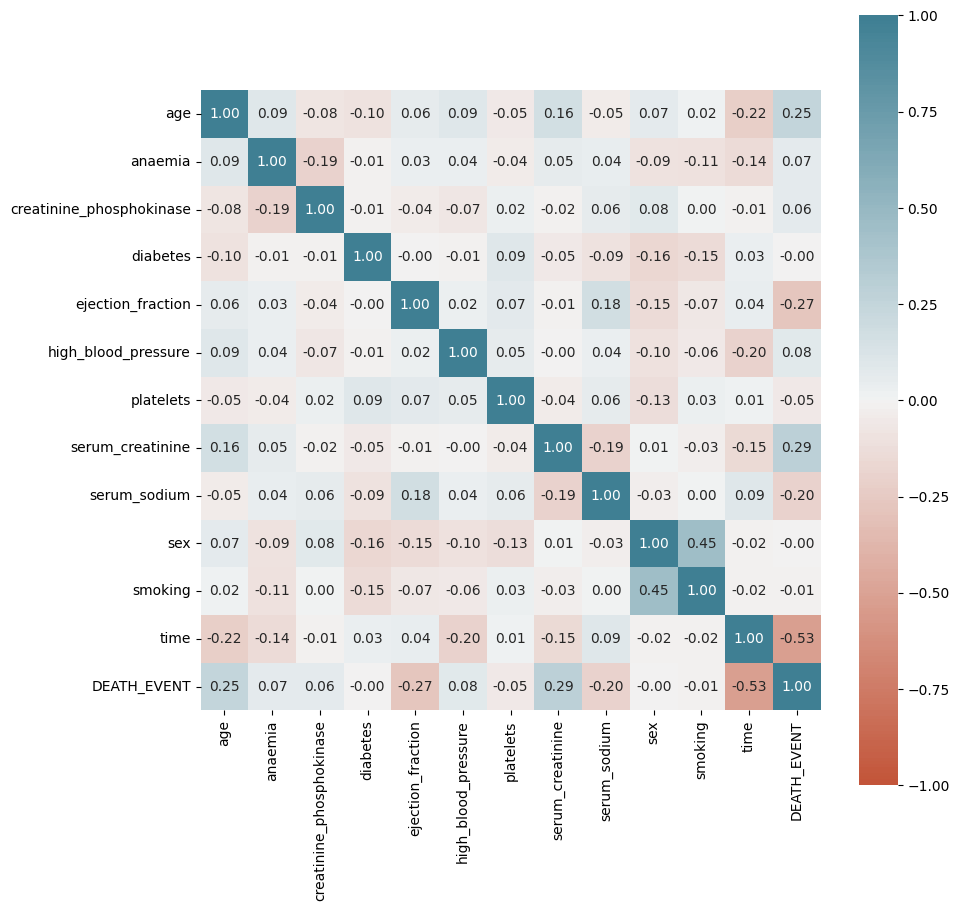

In [8]:
plt.figure( figsize= (10,10))
sns.heatmap(
    heartattacks_df.corr() ,
    annot= True,
    fmt=".2f",
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    #cmap='coolwarm',
    square=True
)


Some features show clear correlations with the target "DEATH_EVENT".
Time, serum_sodium, serum_creatinine, ejection_fraction, age ... are among those.
Perhaps surprisingly (for a non medical doctor, and just contrary to instinct), diabetes, anaemia, smoking or high blood pressure do *not* seem to correlate much to the recovery of a patient after heart failure.

<ipython-input-13-9ef670fa7082>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-13-9ef670fa7082>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Survived', 'Died'])


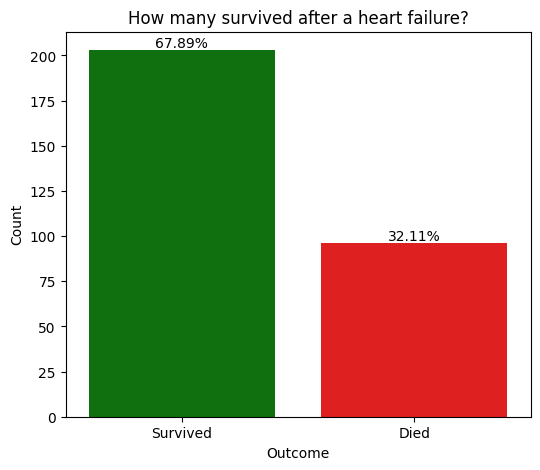

In [13]:
# Target feature balance in the dataset

survival_counts = (heartattacks_df['DEATH_EVENT'].value_counts(normalize=True) * 100 ).round(decimals=2)
survival_counts_abs = heartattacks_df['DEATH_EVENT'].value_counts()

survival_counts_df = pd.DataFrame({
    'DEATH_EVENT'  : survival_counts.index,
    'Percentage': survival_counts.values ,
    'Count'     : survival_counts_abs.values ,
})

plt.figure(figsize=(6 ,5))
ax = sns.barplot(
    data = survival_counts_df,
    y    ='Count'    , x='DEATH_EVENT',
    orient='vertical', palette = ["green", "red"]
)


plt.ylabel('Count', color='black')
plt.xlabel('Outcome')
ax.set_xticklabels(['Survived', 'Died'])
plt.title('How many survived after a heart failure?')

for i, row in survival_counts_df.iterrows():
    percentage = row["Percentage"]
    plt.text( i , row["Count"] , f'{percentage:.2f}%', ha='center', va='bottom' , color = "black")

# plt.savefig('DevAcademy\Projects\\Week07_Neural_Networks\\assignment\\pictures\\survival_chance.jpg', dpi = 150)


The dataset is imbalanced in favour of survivors from a heart attack by 2/3 to 1/3 (deceased)

<ipython-input-5-d1e2019152ba>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)
<ipython-input-5-d1e2019152ba>:89: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


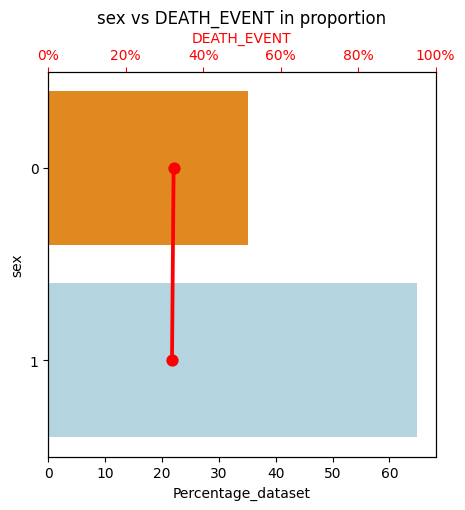

In [14]:
## Relation between "Gender" and "DEATH_EVENT"
# reminder : 0 = Female and 1 = Men

heartattacks_sex_df = prepare_table_cat_and_target(
    data  = heartattacks_df ,
    category_col =  "sex" ,
    target_col   =  "DEATH_EVENT" ,
    sort_order = True
)

plot_cat_and_target(
    data  = heartattacks_sex_df ,
    category_col = "sex"      ,
    target_col   = "DEATH_EVENT" ,
    figure_size = (5, 5) ,
    palette = ["darkorange","lightblue"]
)

<ipython-input-5-d1e2019152ba>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)
<ipython-input-5-d1e2019152ba>:89: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


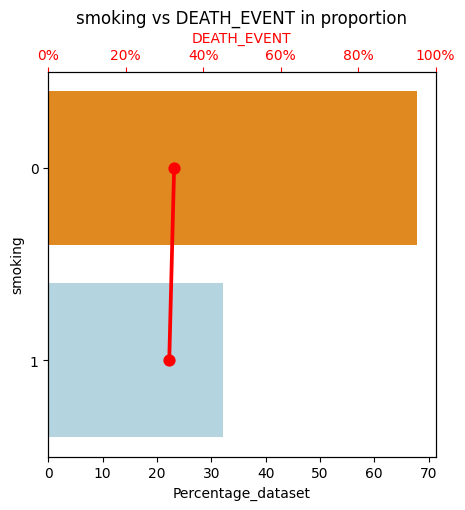

In [15]:
## Relation between "Smoking" and "DEATH_EVENT"
# reminder : 0 = NO and 1 = YES

heartattacks_smoking_df = prepare_table_cat_and_target(
    data  = heartattacks_df ,
    category_col =  "smoking" ,
    target_col   =  "DEATH_EVENT" ,
    sort_order = True
)

plot_cat_and_target(
    data  = heartattacks_smoking_df ,
    category_col = "smoking"      ,
    target_col   = "DEATH_EVENT" ,
    figure_size = (5, 5) ,
    palette = ["darkorange","lightblue"]
)

<ipython-input-5-d1e2019152ba>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)
<ipython-input-5-d1e2019152ba>:89: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


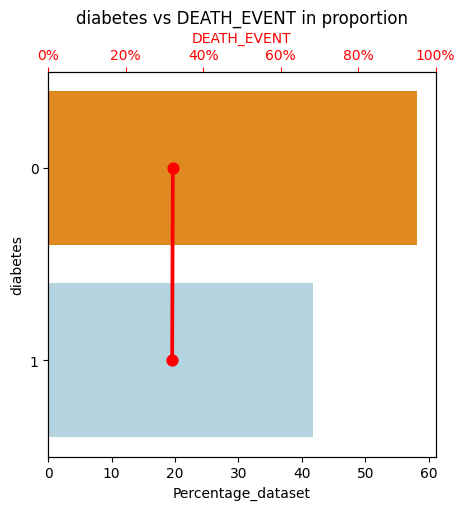

In [16]:
## Relation between "Diabetes" and "DEATH_EVENT"
# reminder : 0 = NO and 1 = YES

heartattacks_diabetes_df = prepare_table_cat_and_target(
    data  = heartattacks_df ,
    category_col =  "diabetes" ,
    target_col   =  "DEATH_EVENT" ,
    sort_order = True
)

plot_cat_and_target(
    data  = heartattacks_diabetes_df ,
    category_col = "diabetes"      ,
    target_col   = "DEATH_EVENT" ,
    figure_size = (5, 5) ,
    palette = ["darkorange","lightblue"]
)

<ipython-input-5-d1e2019152ba>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data, y= category_col, x='Percentage_dataset', orient= "h" , **kwargs)
<ipython-input-5-d1e2019152ba>:89: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


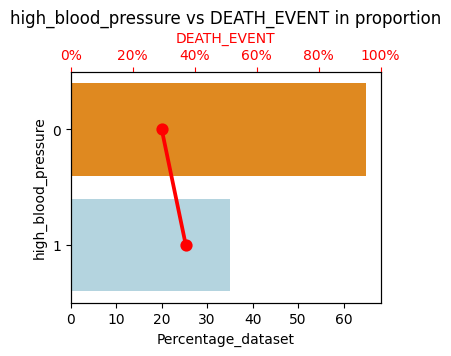

In [18]:
## Relation between "High Blood Pressure" and "DEATH_EVENT"
# reminder : 0 = NO and 1 = YES

heartattacks_diabetes_df = prepare_table_cat_and_target(
    data  = heartattacks_df ,
    category_col =  "high_blood_pressure" ,
    target_col   =  "DEATH_EVENT" ,
    sort_order = True
)

plot_cat_and_target(
    data  = heartattacks_diabetes_df ,
    category_col = "high_blood_pressure"      ,
    target_col   = "DEATH_EVENT" ,
    figure_size = (4, 3) ,
    palette = ["darkorange","lightblue"]
)

In [22]:
## How is "time" (follow up of patients after their heart failure accident) related to our target ?

heartattacks_time_df = heartattacks_df[["time","DEATH_EVENT"]] \
    .assign(
        time_bins = lambda x: pd.cut(x['time'] , np.arange(0,301,30) , right = True )
    ) \
    .groupby(["time_bins","DEATH_EVENT"]) \
    .count()

In [23]:
?sns.catplot

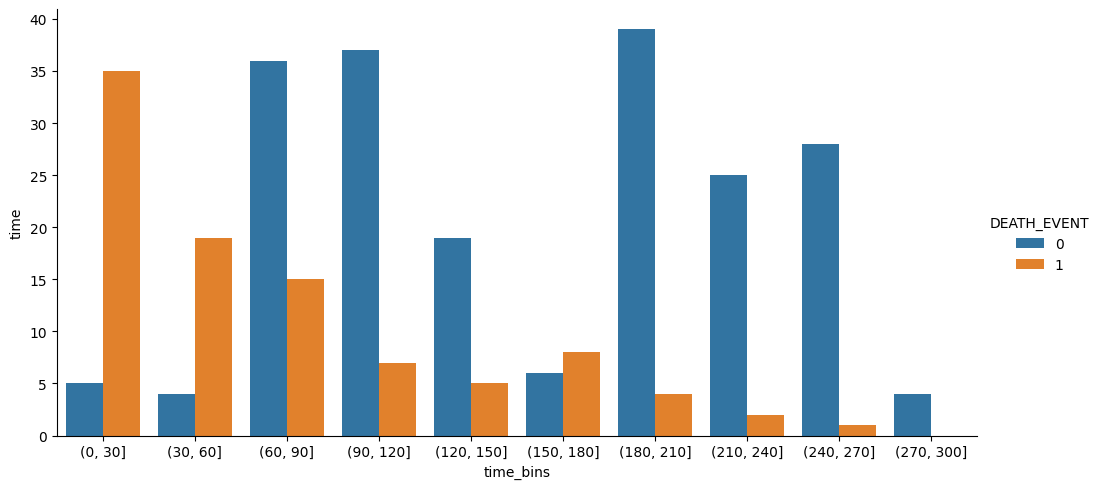

In [25]:
sns.catplot(
    data = heartattacks_time_df.reset_index() ,
    x  =   "time_bins",
    y  =  "time" ,
    hue = "DEATH_EVENT" ,
    kind= "bar" ,
    height = 5,
    aspect = 2
)

In [30]:
heartattacks_age_df = heartattacks_df[["age","DEATH_EVENT"]] \
    .assign(
        age_bins = lambda x: pd.cut(x['age'] , np.arange(40,100,5) , right = True )
    ) \
    .groupby(["age_bins","DEATH_EVENT"]) \
    .count()

heartattacks_age_df.head(3)

age
age_bins DEATH_EVENT     
(40, 45] 0             23
         1              7
(45, 50] 0             25

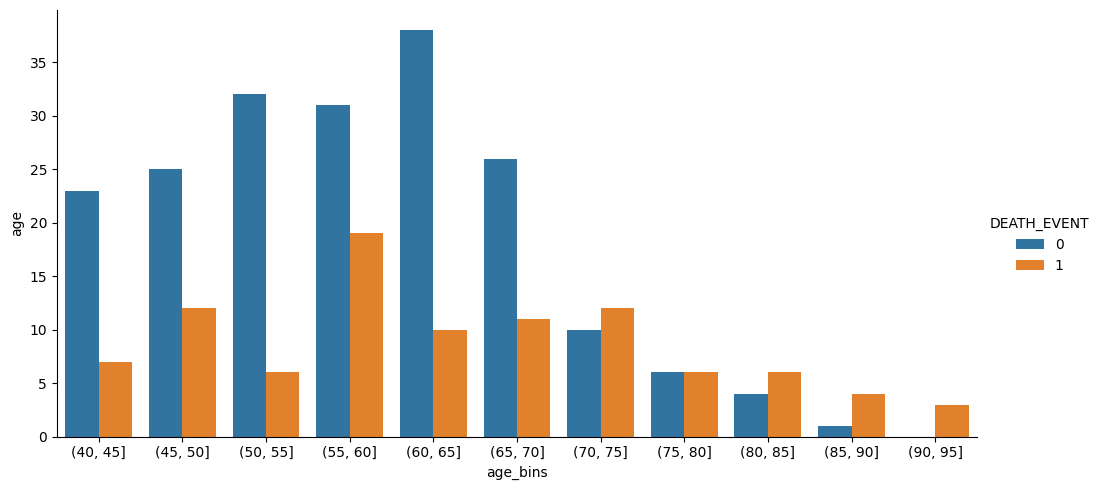

In [31]:
sns.catplot(
    data = heartattacks_age_df.reset_index() ,
    x  =   "age_bins",
    y  =  "age" ,
    hue = "DEATH_EVENT" ,
    kind= "bar" ,
    height = 5,
    aspect = 2
)

Takeaways so far:

Yes, *smoking*, having *diabetes, anaemia* and even *high blood pressure* to some extent do not seem to play a big role in a patients recovery after heart failure.

*age* has a definite role. The previous histogram shows that while most patients aged 40 to 69 years old survive the consequences of a heart failure (across the time they were followed up), this trend reverses for patients aged above 70 year old.

*time* is an unclear feature. As *time* refers to some medical follow-up time in days, aka when these patients went to consult their doctor, is it a coincidence that many who were scheduled for a follow-up within 2 months (60 days) died ?

It could be that patients perceived as at higher risk following a heart attack were scheduled for said follow-up, as their case required closer attention. Let us find out by exploring how age, (follow-up) time and survival status (DEATH_EVENT) are related.



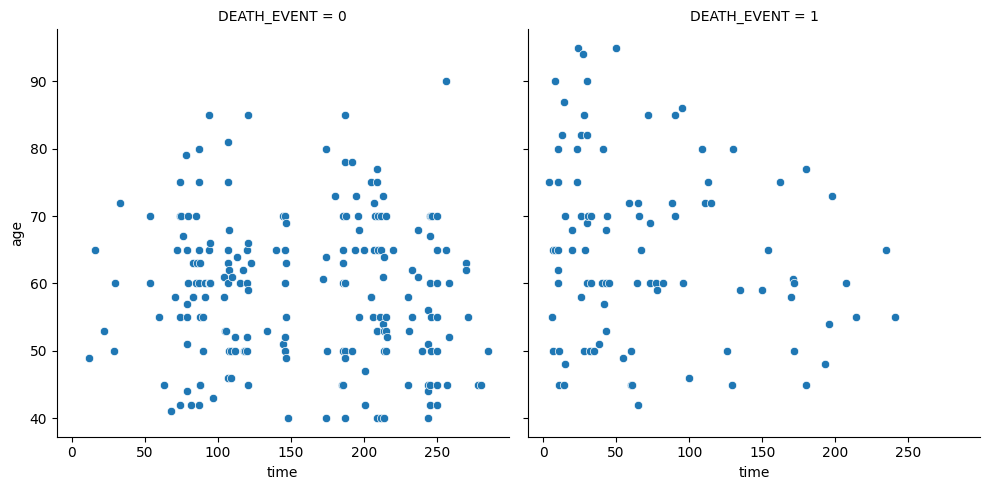

In [33]:
grid = sns.FacetGrid(
    data = heartattacks_df ,
    col="DEATH_EVENT",
    margin_titles=True ,
    height = 5 ,
    aspect = 1
)

# Plot accuracy against epochs in each facet
grid.map(sns.scatterplot, "time" ,  "age" )

For those who survived, the dataset shows no clear pattern : patient age and follow up time are distributed across the whole distribution. However, only few were scheduled for a follow-up within the first 50 days.
In contrast, in the "deceased" category, many were scheduled for a checkup within the first 60 days. This confirms earlier suspicions that higher risk patients were scheduled for a quick followup following their accidents.


Regarding the other numerical features (serum etc...), let us assess how values are distributed, as we mentioned some skewed distributions earlier in the analysis.


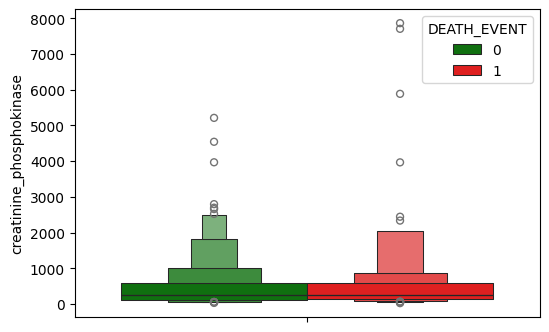

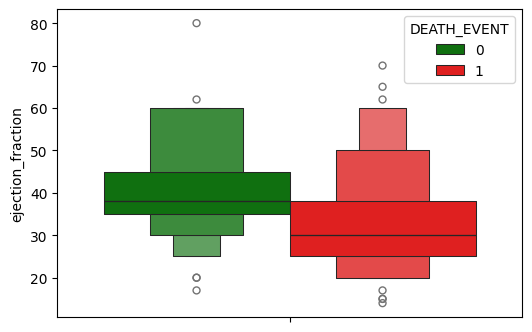

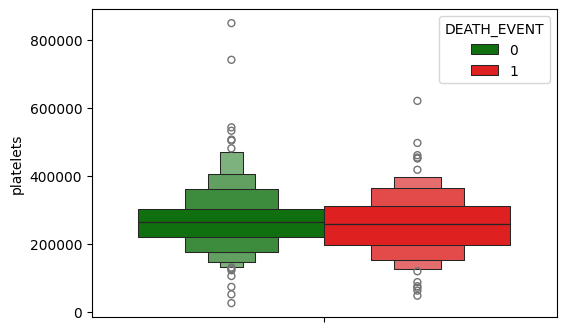

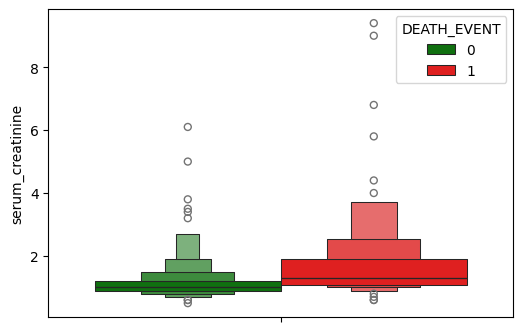

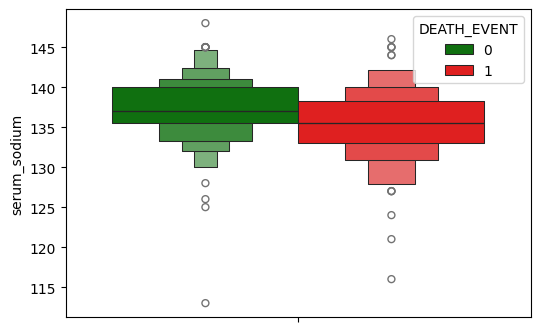

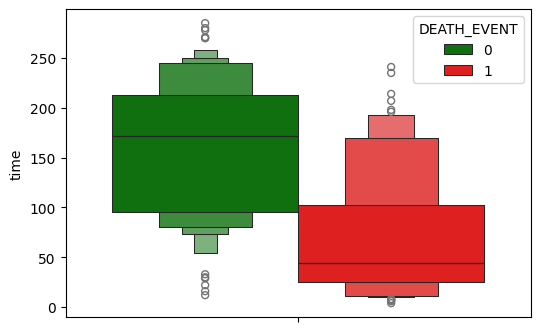

In [37]:
# Checking for potential outliers using the "Boxen and Swarm plots" of non binary features.
features = ["creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium", "time"]
cols= ["green","red"]
for feature in features:
    plt.figure(figsize=(6,4))
    sns.boxenplot(hue=heartattacks_df["DEATH_EVENT"], y=heartattacks_df[feature], palette=cols)
    # path_save = 'C:\\DevAcademy\Projects\\Week07_Neural_Networks\\assignment\\pictures\\feature' + feature + '_chance.jpg'
    # plt.savefig( path_save , dpi = 150)
    plt.show()


*creatinine_phosphokinase* , *serum_creatinine* and possibly *platelets* show clear outliers as compared to the other numerical variables.

What to do with perceived outliers is always a bit tricky. Removing them may not be such a good idea, as it would reduce our dataset which is already limited to 300 patients, and the dataset still remains to be splitted between Train/Test later on, further limiting training possibilities.
Capping them would better be done with the educated guess/advice from someone knowledgeable in the medical field, to identify whether some values are clearly outliers/mistakes or what an acceptable cap would be.

In our case, we will keep the data as it is as the skew due to outliers is not that severe.

#  PRE PROCESSING  ---- PRE PROCESSING

The dataset contains features all expressed numerically but some are obviously categorical binary variables and maybe should be treated as such. Since these are binary categories, one may or may not want to scale them along with the continuous numerical variables.

The dataset is also limited so KFold cross validations may produce too small dataset folds to train on. We thus created 4 configurations as detailed below.


- *Config 1* : all numerical (categorical + numerical) lumped together | all standard scaled | train/test split not considering imbalance | stratified 10 K fold

- *Config 2* : numerical scaled + categorical enforced as such but not scaled | standard scaled | train/test split with imbalanced considered | stratified 10 K fold

- *Config 3* : all numerical (categorical + numerical) lumped together | all standard scaled | train/test split not considering imbalance | stratified 5 K fold

- *Config 4* : numerical scaled + categorical enforced as such but not scaled | standard scaled | train/test split with imbalanced considered | stratified 5 K fold

In [38]:
y = heartattacks_df[["DEATH_EVENT"]]
# y = heartattacks_df.iloc[:,-1]

# ENCODING

# COMBINING NUM & CAT VARIABLES +  SCALING

In [ ]:
# 1st version where numerical and categorical are scaled together

numerical_var   = heartattacks_df.iloc[:,:-1 ]

std_scaler  = StandardScaler()
X = numerical_var.copy()

X_scaled    = std_scaler.fit_transform(X)

In [40]:
# 2nd version treating cat variables differently

numerical_var   = heartattacks_df[["age","creatinine_phosphokinase","ejection_fraction", "platelets" ,
                                 "serum_creatinine", "serum_sodium","time"]]

categorical_var = heartattacks_df[["anaemia","diabetes","high_blood_pressure","sex","smoking"]]
for column in categorical_var.columns:
    categorical_var[column] = pd.Categorical( categorical_var[column]  )


std_scaler = StandardScaler()
X = numerical_var.copy()
X_scaled = std_scaler.fit_transform(X)

X_scaled = np.concatenate( [ X_scaled , categorical_var.to_numpy() ] , axis = 1 )

<ipython-input-40-3e22815d1a45>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_var[column] = pd.Categorical( categorical_var[column]  )


In [41]:
# ensure array is the right combination of scaled numerical and encoded categorical

print(X_scaled.shape)
X_scaled[1]

(299, 12)


array([-0.4912792759632972, 7.514639528854929, -0.007076750175989039,
       7.535660178453291e-09, -0.2845523523500058, -0.14197615085423837,
       -1.6036907368917659, 0, 0, 0, 1, 0], dtype=object)

In [42]:
X_flat = X_scaled.copy()
y_flat = y.values.flatten()

# SPLITTING THE DATA  INTO TRAINING/TESTING

In [ ]:
# 1) NOT considering the imbalance
X_train, X_test, y_train, y_test = train_test_split(X_flat , y_flat , test_size= 0.2 , random_state = 2 )

# Check balance of data
dataset_0, dataset_1 =  len( y_flat[y_flat ==0])/ len(y_flat )*100  , len(y_flat[y_flat==1])/len(y_flat)*100

# Check balance in %tage
train_0, train_1     =  len(y_train[y_train==0])/ len(y_train)*100  , len(y_train[y_train==1]) / len(y_train)*100
test_0, test_1       =  len(y_test[y_test==0])  / len(y_test)*100   , len(y_test[y_test==1])   / len(y_test)*100

print('> Original dataset: 0 = %.2f, 1 = %.2f ' % (dataset_0, dataset_1))
print('> Train: 0 = %.2f, 1 = %.2f   |||   Test: 0 = %.2f, 1 = %.2f' % (train_0, train_1, test_0, test_1))

In [ ]:
# Check balance in Absolute value
dataset_0, dataset_1 =  len( y_flat[y_flat ==0])/ len(y_flat )*100  , len(y_flat[y_flat==1])/len(y_flat)*100
train_0, train_1     =  len(y_train[y_train==0])  , len(y_train[y_train==1])
test_0 , test_1      =  len(y_test[y_test==0])   , len(y_test[y_test==1])
print('> Original dataset: 0 = %.2f, 1 = %.2f ' % (dataset_0, dataset_1))
print('> Train: 0 = %d, 1 = %d   |||   Test: 0 = %d, 1 = %d' % (train_0, train_1, test_0, test_1))

In [43]:
# 2) WITH considering the imbalance

X_train, X_test, y_train, y_test = train_test_split(X_flat , y_flat , test_size= 0.2 , random_state = 1 , stratify = y_flat)

# Check balance In %tage :
dataset_0, dataset_1 =  len( y_flat[y_flat ==0])/ len(y_flat )*100  , len(y_flat[y_flat==1])   / len(y)*100
train_0, train_1     =  len(y_train[y_train==0])/ len(y_train)*100  , len(y_train[y_train==1]) / len(y_train)*100
test_0, test_1       =  len(y_test[y_test==0])  / len(y_test)*100   , len(y_test[y_test==1])   / len(y_test)*100
print('> Original dataset: 0 = %.2f, 1 = %.2f ' % (dataset_0, dataset_1))
print('> Train: 0 = %.2f, 1 = %.2f   |||   Test: 0 = %.2f, 1 = %.2f' % (train_0, train_1, test_0, test_1))

> Original dataset: 0 = 67.89, 1 = 32.11 
> Train: 0 = 67.78, 1 = 32.22   |||   Test: 0 = 68.33, 1 = 31.67


In [44]:
# Check balance in Absolute value :
dataset_0, dataset_1 =  len( y_flat[y_flat ==0])/ len(y_flat )*100  , len(y_flat[y_flat==1])/len(y_flat)*100
train_0, train_1     =  len(y_train[y_train==0]) , len(y_train[y_train==1])
test_0 , test_1      =  len(y_test[y_test==0])   , len(y_test[y_test==1])
print('> Original dataset: 0 = %.2f, 1 = %.2f ' % (dataset_0, dataset_1))
print('> Train: 0 = %d, 1 = %d   |||   Test: 0 = %d, 1 = %d' % (train_0, train_1, test_0, test_1))

> Original dataset: 0 = 67.89, 1 = 32.11 
> Train: 0 = 162, 1 = 77   |||   Test: 0 = 41, 1 = 19


# USING "REGULAR" CLASSIFIERS

Before using the ANN for the prediction, we used "regular" ML algorithms suitable for classification in order to find out how simpler algorithms would perform on such task. It also provides a baseline to compare our ANN to later on.

We opted for Kfold Stratified Cross Validation, which, as compared to regular Kfold, respects the dataset balance when folding the data for training.

We run the code below for each of the 4 configurations previously described, respecting the target imbalance or not, treating categorical variables as such or not (i.e. numerical and scaled)

We finally saved the data externally for later comparisons if necessary

In [ ]:
# Prepare ML Algorithms
models = []
models.append(('LogReg', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNeig', KNeighborsClassifier()))
models.append(('Dec Tree', DecisionTreeClassifier()))
models.append(('Gauss', GaussianNB()))
models.append(('SVM', svm.SVC(gamma='auto')))

In [ ]:
# Run the Kfold an save results
results = []
names   = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train , cv = kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


In [ ]:
# Compare Algorithms Visually
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.xlabel("algorithm")
plt.ylabel("Accuracy")


In [ ]:
# define a function to compute row average
def row_average(row):
    return row.mean()

def row_median(row):
    return row.median()

In [ ]:
config_results = pd.DataFrame( results , index = names )
config_results["mean"] = config_results.apply( row_average, axis = 1)
config_results["median"] = config_results.apply( row_median, axis = 1)
config_results.to_csv("Week7_Intro_ANN/config1_results.csv")

**Config 1** : all numerical (cat + num) lumped / all standard scaled / train/test split balanced / stratified 10 K fold

**Config 2** : numerical scaled + cat enforced as such but not scaled / standard scaled / train/test split balanced / stratified 10 K fold

**Config 3** : all numerical (cat + num) lumped  / standard scaled / train/test split balanced / stratified 5 K fold

**Config 4** : numerical scaled + cat enforced as such but not scaled / standard scaled / train/test split balanced / stratified 5 K fold

# NEURAL NETWORKS

In [45]:
print(X_train[:3],"\n")

print(X_train.shape)

[[-0.6597017266098202 -0.542850237960543 1.0085784350819558
  0.4572072956180517 -0.6718570222152697 -0.36898614607037217
  1.3001229661925195 0 0 0 1 1]
 [-0.23864559999351267 -0.5387208389769091 -0.007076750175989039
  -1.1302479545147432 4.2662775185668425 -0.5959961412865059
  -1.345573963284274 1 0 0 1 0]
 [-1.3333915291959122 7.350495919255485 -1.1073698675387627
  1.2970223311721756 -0.3813785198163218 0.5390538347941629
  -0.9067754481515374 0 1 1 1 0]] 

(239, 12)


In [46]:
print(y_train[:3] , "\n")

print(y_train.shape)

[0 1 1] 

(239,)


In [47]:
# This step is apparently needed by TF to avoid possible error when fitting the ANN later

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')



In [ ]:
# Initialize your model network
model = Sequential()

# Input Layer
model.add(Dense(units = 16 , kernel_initializer =  "uniform",
                activation = "relu",
                input_dim = 12))

# Hidden layer 1
model.add(Dense(units = 8 , kernel_initializer =  "uniform",
                activation = "relu"))

# Hidden layer 2
model.add(Dense(units = 4 , kernel_initializer =  "uniform",
                activation = "relu"))


## Regularisation
model.add(Dropout(0.25))


# Output layer
# model.add(Dense(units= 8 , kernel_initializer = "uniform", activation = "relu"))
model.add(Dense(units= 1 , kernel_initializer = "uniform", activation = "sigmoid"))

In [ ]:
#compiling the network
## optimizer : adam, sgd - stochastc gradient descent, rmsprop (root mean square propagation)
model.compile(optimizer = "adam", loss = "binary_crossentropy" , metrics = ["accuracy"] )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                208       
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train your network
history = model.fit(X_train, y_train , batch_size = 24 , epochs = 100 , validation_split= 0.10 )

Epoch 1/100
9/9 [==============================] - 1s 24ms/step - loss: 0.6925 - accuracy: 0.6651 - val_loss: 0.6905 - val_accuracy: 0.7917
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.6910 - accuracy: 0.6651 - val_loss: 0.6876 - val_accuracy: 0.7917
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.6651 - val_loss: 0.6844 - val_accuracy: 0.7917
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.6651 - val_loss: 0.6805 - val_accuracy: 0.7917
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.6651 - val_loss: 0.6751 - val_accuracy: 0.7917
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6651 - val_loss: 0.6672 - val_accuracy: 0.7917
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.6651 - val_loss: 0.6547 - val_accuracy: 0.7917
Epoch 8/100
9/9 [=========

In [ ]:
test_history = pd.DataFrame(history.history)

test_history.index.name = "epoch"

test_history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,0.181584,0.932773,0.337219,0.925000
1,0.219373,0.907563,0.338122,0.925000
2,0.219359,0.907563,0.339029,0.925000
3,0.181824,0.932773,0.340256,0.933333
4,0.231984,0.899160,0.341402,0.933333
...,...,...,...,...
95,0.257192,0.882353,0.351338,0.908333
96,0.232009,0.899160,0.352674,0.908333
97,0.219317,0.907563,0.353901,0.908333


The model reached a higher result than "regular" ML algorithms with basic input parameters (batch size, validation split).
Because we want to see whether the model improved with different inputs (not playing with the architecture), we opted to scale the analysis and explore different inputs

In [48]:
# Create a function to reinitialise the model between iterations

def initialise_model():
  model = Sequential()

  # Input Layer
  model.add(Dense(units = 16 , kernel_initializer =  "uniform",
                  activation = "relu",
                  input_dim = 12))

  # Hidden layer 1
  model.add(Dense(units = 8 , kernel_initializer =  "uniform",
                  activation = "relu"))

  # Hidden layer 2
  model.add(Dense(units = 4 , kernel_initializer =  "uniform",
                  activation = "relu"))


  ## Regularisation
  model.add(Dropout(0.25))


  # Output layer
  # model.add(Dense(units= 8 , kernel_initializer = "uniform", activation = "relu"))
  model.add(Dense(units= 1 , kernel_initializer = "uniform", activation = "sigmoid"))

  model.compile(optimizer = "adam", loss = "binary_crossentropy" , metrics = ["accuracy"] )

  return model

In [ ]:
model = initialise_model()

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 16)                208       
                                                                 
 dense_117 (Dense)           (None, 8)                 136       
                                                                 
 dense_118 (Dense)           (None, 4)                 36        
                                                                 
 dropout_29 (Dropout)        (None, 4)                 0         
                                                                 
 dense_119 (Dense)           (None, 1)                 5         
                                                                 
Total params: 385 (1.50 KB)
Trainable params: 385 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train based on multiple configurations

# Define the ranges for batch_size and validation_split
batch_sizes       = [24, 36, 48 , 60 , 72 ] # 10,15...,30% of the rows in Train dataset
validation_splits = [0.1 , 0.2 ,0.3, 0.4, 0.5]

# Initialize dictionary to store configurations and history
config_history_collection = {}

# Iterate over batch_sizes and validation_splits
for batch_size in batch_sizes:
    for validation_split in validation_splits:
        # Fit the model with current batch_size and validation_split
        model = initialise_model()
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=100, validation_split=validation_split, verbose=0)

        # Convert history to DataFrame
        history_df  = pd.DataFrame(history.history)
        history_df.index.name = "epoch"
        _, accuracy = model.evaluate(X_train, y_train)

        # Store configuration and history in the dictionary
        config_history_collection[(batch_size, validation_split)] = {
            'batch_size'      : batch_size,
            'validation_split': validation_split ,
            'avg_accuracy'    : accuracy ,
            'history'         : history_df,

        }

    print(f"All validation splits for Batch size of {batch_size} accomplished !")



8/8 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8619
All validation splits for Batch size of 24 accomplished !
8/8 [==============================] - 0s 2ms/step - loss: 0.4431 - accuracy: 0.8368
All validation splits for Batch size of 36 accomplished !
8/8 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.6778
All validation splits for Batch size of 48 accomplished !
8/8 [==============================] - 0s 2ms/step - loss: 0.6648 - accuracy: 0.6778
All validation splits for Batch size of 60 accomplished !
8/8 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8368
All validation splits for Batch size of 72 accomplished !


In [ ]:
# Testing whether data were correctly recorded

first_key = list(config_history_collection)[0]
config_history_collection[first_key]


{'batch_size': 24,
 'validation_split': 0.1,
 'avg_accuracy': 0.8828451633453369,
 'history':            loss  accuracy  val_loss  val_accuracy
 epoch                                            
 0      0.692400  0.641860  0.690362      0.791667
 1      0.690851  0.665116  0.687665      0.791667
 2      0.689290  0.665116  0.684659      0.791667
 3      0.687552  0.665116  0.681202      0.791667
 4      0.685396  0.665116  0.677109      0.791667
 ...         ...       ...       ...           ...
 95     0.375193  0.879070  0.264550      0.916667
 96     0.399744  0.874419  0.265391      0.916667
 97     0.385748  0.860465  0.263505      0.916667
 98     0.391264  0.860465  0.263384      0.916667
 99     0.397048  0.846512  0.263821      0.916667
 
 [100 rows x 4 columns]}

In [ ]:
#  Combining all saved data from all configurations into a larger dataframe

data = []
data_coll = []
# Iterate over the config_history dictionary
for key, value in config_history_collection.items():
    # Extract batch_size and validation_split
    batch_size, validation_split  = key
    # Append the history, batch_size, and validation_split to the data list
    #data.append({'history': value['history'], 'batch_size': batch_size, 'validation_split': validation_split})
    data = value["history"]
    data["batch_size"] = batch_size
    data["validation_split"] = validation_split
    data["avg_accuracy"]     = value["avg_accuracy"]
    data_coll.append(data)

data_coll_df = pd.concat(data_coll)

# Checking the first and last 3 rows
print(data_coll_df.head(3))
print(data_coll_df.tail(3))

           loss  accuracy  val_loss  val_accuracy  batch_size  \
epoch                                                           
0      0.692400  0.641860  0.690362      0.791667          24   
1      0.690851  0.665116  0.687665      0.791667          24   
2      0.689290  0.665116  0.684659      0.791667          24   

       validation_split  avg_accuracy  
epoch                                  
0                   0.1      0.882845  
1                   0.1      0.882845  
2                   0.1      0.882845  


In [ ]:
# Pulling out the top 5 ANN model configurations in terms of accuracy

data_coll_df[["validation_split","batch_size","avg_accuracy"]].drop_duplicates().sort_values("avg_accuracy" , ascending = False).head(5)

,validation_split,batch_size,avg_accuracy
epoch,,,
0,0.1,24,0.882845
0,0.3,36,0.878661
0,0.2,24,0.874477
0,0.1,60,0.870293
0,0.4,24,0.866109


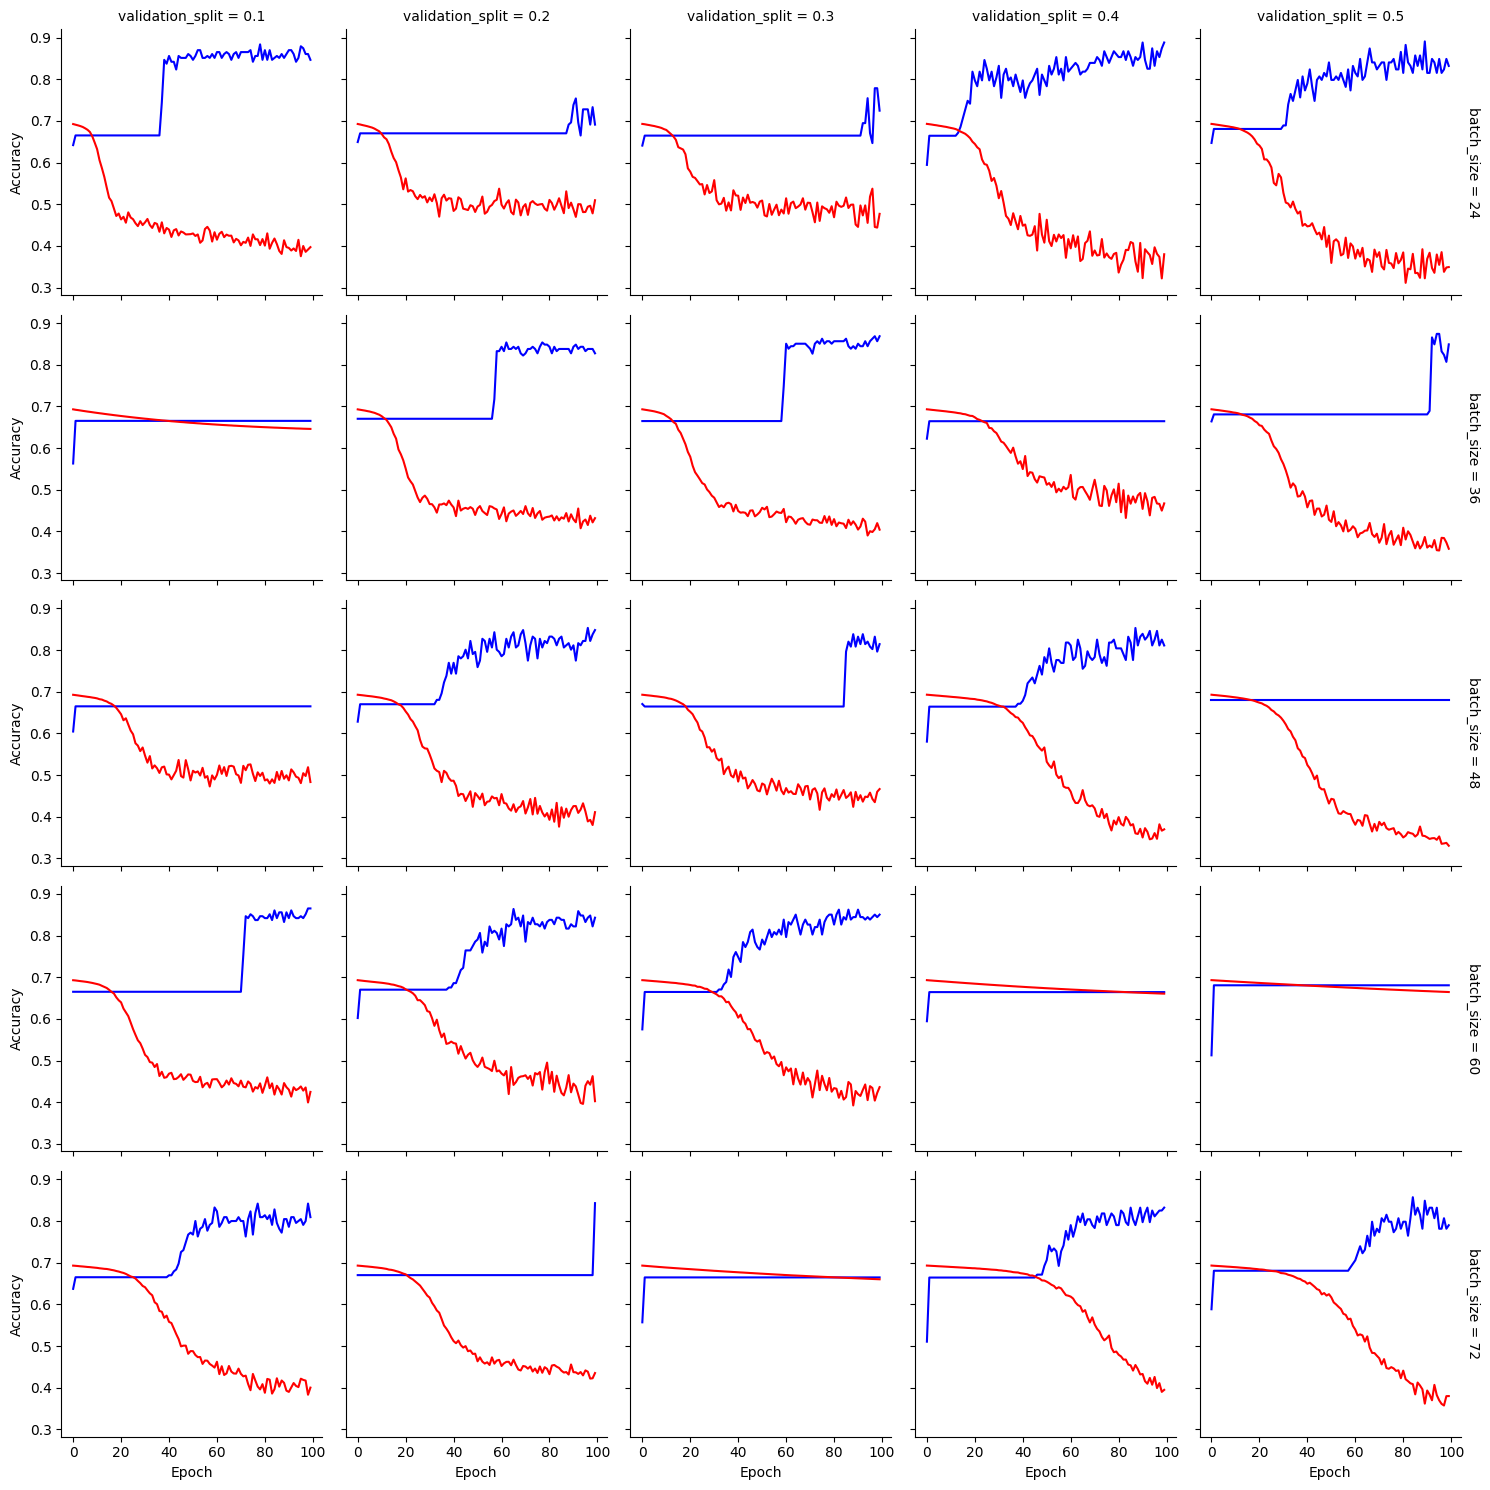

In [ ]:
##  Plotting the accuracy and loss evolution across epochs for all considered configurations

# Create facet grid based on validation_split and batch_size
grid = sns.FacetGrid(
    data = data_coll_df.reset_index() ,
    col="validation_split", row="batch_size",
    margin_titles=True
)

# Plot accuracy against epochs in each facet
grid.map(sns.lineplot, "epoch" ,  "accuracy", color = "blue")
grid.map(sns.lineplot, "epoch" ,  "loss" , color = "red")

# Set titles and labels
grid.set_titles("Validation Split: {col_name}\nBatch Size: {row_name}")
grid.set_axis_labels("Epoch", "Accuracy")
# plt.legend(['accuracy', 'loss'], loc='lower left')

## RED : loss /// BLUE = Accuracy

# Adjust layout
plt.tight_layout()

# Predictions with the best performing Configuration

the top model previously identified is recreated, retrained and will then be used to make predictions on the test fold.

In [49]:
model = initialise_model()
history = model.fit(X_train, y_train, batch_size= 24, epochs=100, validation_split= 0.1, verbose=0)

# Convert history to DataFrame
history_df            = pd.DataFrame(history.history)
history_df.index.name = "epoch"
_, accuracy           = model.evaluate(X_train, y_train)

print(accuracy)
history_df.tail(3)

8/8 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.8828
0.8828451633453369


,loss,accuracy,val_loss,val_accuracy
epoch,,,,
97,0.414602,0.818605,0.277085,0.916667
98,0.410325,0.813953,0.276719,0.916667
99,0.429082,0.786047,0.276944,0.916667


In [50]:
# Predict
y_pred_ann = model.predict(X_test)
y_pred_ann[:3]

2/2 [==============================] - 1s 11ms/step


array([[0.13570324],
       [0.08281133],
       [0.8573851 ]], dtype=float32)

In [51]:
# set a threshold
y_pred_ann = np.where(y_pred_ann > 0.5 , 1 , 0)
y_pred_ann[:3]

array([[0],
       [0],
       [1]])

In [52]:
print("test values:" ,y_test[:3])
print("predicted values:" , y_pred_ann[:3])

test values: [0. 0. 0.]
predicted values: [[0]
 [0]
 [1]]


In [53]:
print(y_test.shape)
print(y_pred_ann.shape)

(60,)
(60, 1)


In [54]:
y_pred_ann.flatten().shape

(60,)

In [55]:
pd.DataFrame({ "Actual" : y_test , "Predicted" : y_pred_ann.flatten() } )

print(classification_report( y_test , y_pred_ann.flatten() ))

cm = confusion_matrix(y_test , y_pred_ann.flatten() )
cm


              precision    recall  f1-score   support

         0.0       0.83      0.93      0.87        41
         1.0       0.79      0.58      0.67        19

    accuracy                           0.82        60
   macro avg       0.81      0.75      0.77        60
weighted avg       0.81      0.82      0.81        60



array([[38,  3],
       [ 8, 11]])

Text(0.5, 1.0, 'Confusion Matrix')

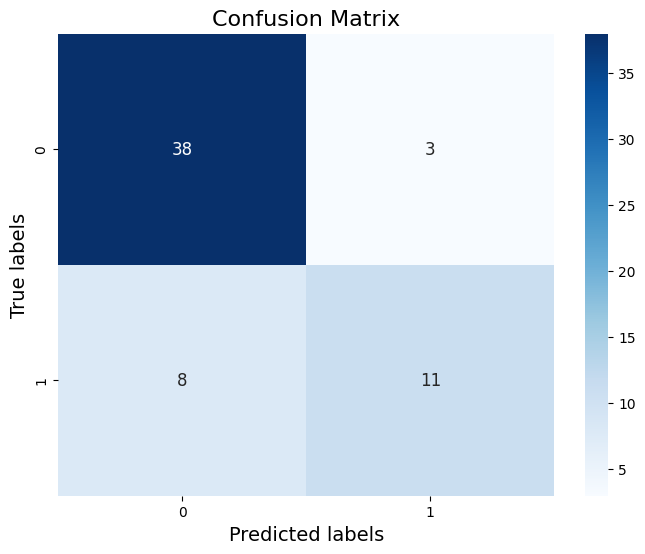

In [56]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 12})

# Add labels and title
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

In [59]:
(38+11)/(38+11+8+3)

0.8166666666666667

The accuracy on the test dataset amounts to about 82% based on the previous results, down from the average 88% during the training run.

# Display Training History

Text(0.5, 1.0, 'Model Accuracy Value and Value Accuracy')

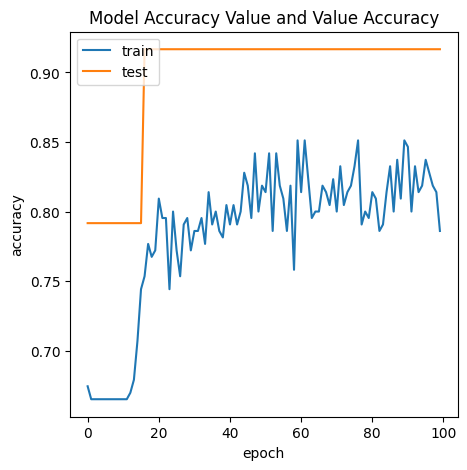

In [60]:
# Accuracy
plt.figure( figsize = (5,5))
plt.plot(history.history["accuracy"] )
plt.plot(history.history["val_accuracy"] )
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'train_validation_fold'], loc='upper left')
plt.title("Model Accuracy for Train and Train validation fold")

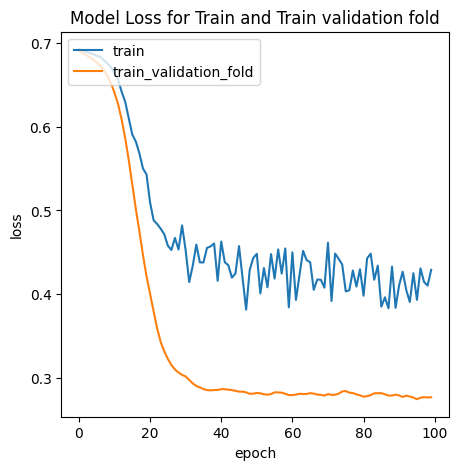

In [61]:
# Loss
plt.figure( figsize = (5,5))
plt.plot(history.history["loss"] )
plt.plot(history.history["val_loss"] )
plt.title("Model Loss for Train and Train validation fold")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'train_validation_fold'], loc='upper left')

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.692519,0.674419,0.690556,0.791667
1,0.691000,0.665116,0.688168,0.791667
2,0.689689,0.665116,0.685668,0.791667
3,0.688142,0.665116,0.683042,0.791667
4,0.686731,0.665116,0.680165,0.791667
...,...,...,...,...
95,0.393274,0.837209,0.274614,0.916667
96,0.430821,0.827907,0.276472,0.916667
97,0.414602,0.818605,0.277085,0.916667
98,0.410325,0.813953,0.276719,0.916667
